In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
mbti2 = pd.read_excel("dataset/mbti_extroverted-dataset.xlsx")

###TASK 1: Dataset Inspection###
#inspecting the datasets
def inspect_dataset(df,name="Dataset"):
  print(f"/n====={name} INSPECTION=====")

#looking through shape and info about the datasets
  print(f"Shape: {df.shape}")
  print(f"Columns: {df.columns}")
  print("Info:")
  print(df.info())

  print("\nHead:")
  print(df.head())
#missing values
  print("\nMissing Values per Column:")
  print(df.isnull().sum())

#summary statistics
  print("\nSummary Statistics:(numeric columns):")
  print(df.describe())

  #for checking outliers
  print("\nOutlier Check (based on IQR, numeric columns):")
  numeric_cols = df.select_dtypes(include=[np.number]).columns
  for col in numeric_cols:
      q1 = df[col].quantile(0.25)
      q3 = df[col].quantile(0.75)
      iqr = q3 - q1

      outliers = df[(df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))]
      print(f"{col}: {len(outliers)} potential outliers")

  print("="*50)

# Inspecting all the datasets
inspect_dataset(mbti2, "MBTI Extroverted Dataset")



/n=====MBTI Extroverted Dataset INSPECTION=====
Shape: (81204, 2)
Columns: Index(['type', 'posts'], dtype='object')
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81204 entries, 0 to 81203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    81204 non-null  object
 1   posts   81204 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None

Head:
   type                                              posts
0  ESTP  # To marry Zhong Han Liang #|||Zhong Han Liang...
1  ISFJ  However, the wood belt / / @Green Bean Fries: ...
2  INFJ  Ha|||Ha-ha-ha-ha-ha|||@RubyDedidi:Repost|||# h...
3  ISTP  I don't know if there's any yogurt|||Once almo...
4  INFP  In short, Qin time, Kyushu, Wushu. Four swords...

Missing Values per Column:
type     0
posts    0
dtype: int64

Summary Statistics:(numeric columns):
         type  posts
count   81204  81204
unique     14  69394
top      INFJ      /
freq    27087   1003

Outlier Chec

In [3]:
### TASK 2: Clean data, remove stopwords and tokenize text ###


# Prepare stop words (combine sklearn's stop words with NLTK's if available)
stop_words = set(ENGLISH_STOP_WORDS)
try:
    from nltk.corpus import stopwords as nltk_stop
    stop_words = stop_words.union(set(nltk_stop.words('english')))
except Exception:
    # NLTK stopwords may not be downloaded in this environment; it's ok to proceed
    pass

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

mbti2['cleaned_text'] = mbti2.get('posts', '') .apply(clean_text) if 'posts' in mbti2.columns else ''

# TF-IDF vectorizer (only run if cleaned text present)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5)
if 'cleaned_text' in mbti2.columns and mbti2['cleaned_text'].astype(bool).any():
    X = vectorizer.fit_transform(mbti2['cleaned_text'])
    y = mbti2['type'] if 'type' in mbti2.columns else None
else:
    X = None
    y = None

mbti2.head()

,type,posts,cleaned_text
0,ESTP,# To marry Zhong Han Liang #|||Zhong Han Liang...,marry zhong han liang zhong han liang finish c...
1,ISFJ,"However, the wood belt / / @Green Bean Fries: ...",wood belt green bean fries reaction drinking s...
2,INFJ,Ha|||Ha-ha-ha-ha-ha|||@RubyDedidi:Repost|||# h...,hahahahahaharubydedidirepost ho po ho po pick ...
3,ISTP,I don't know if there's any yogurt|||Once almo...,dont know theres yogurtonce powdered zzzoey ye...
4,INFP,"In short, Qin time, Kyushu, Wushu. Four swords...",short qin time kyushu wushu swords half ancien...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23224\1568059520.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='type', data=mbti2, order=mbti2['type'].value_counts().index, palette='crest')


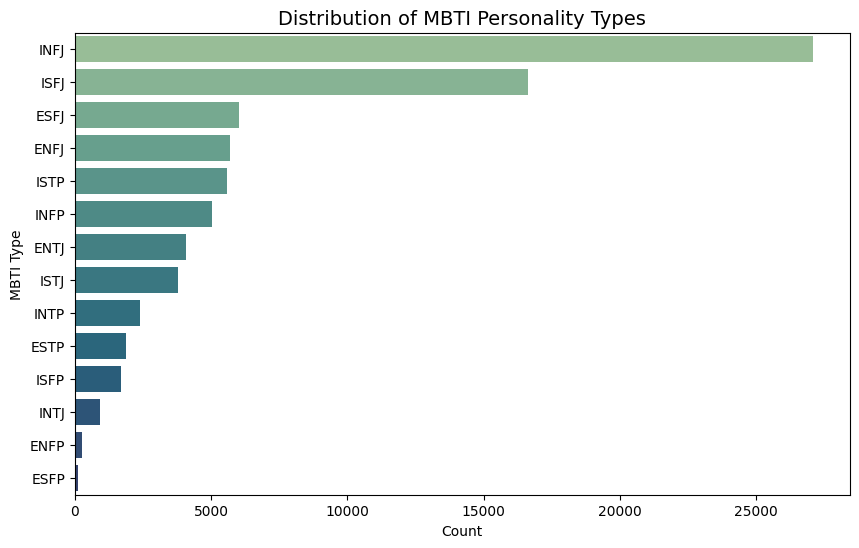


MBTI Type Distribution (%):
 type
INFJ    33.36
ISFJ    20.48
ESFJ     7.42
ENFJ     7.00
ISTP     6.89
INFP     6.20
ENTJ     5.02
ISTJ     4.67
INTP     2.96
ESTP     2.33
ISFP     2.07
INTJ     1.12
ENFP     0.33
ESFP     0.15
Name: proportion, dtype: float64


In [4]:
#  MBTI type distribution 
plt.figure(figsize=(10,6))
sns.countplot(y='type', data=mbti2, order=mbti2['type'].value_counts().index, palette='crest')
plt.title("Distribution of MBTI Personality Types", fontsize=14)
plt.xlabel("Count")
plt.ylabel("MBTI Type")
plt.show()

# Display % distribution
type_dist = (mbti2['type'].value_counts(normalize=True) * 100).round(2)
print("\nMBTI Type Distribution (%):\n", type_dist)

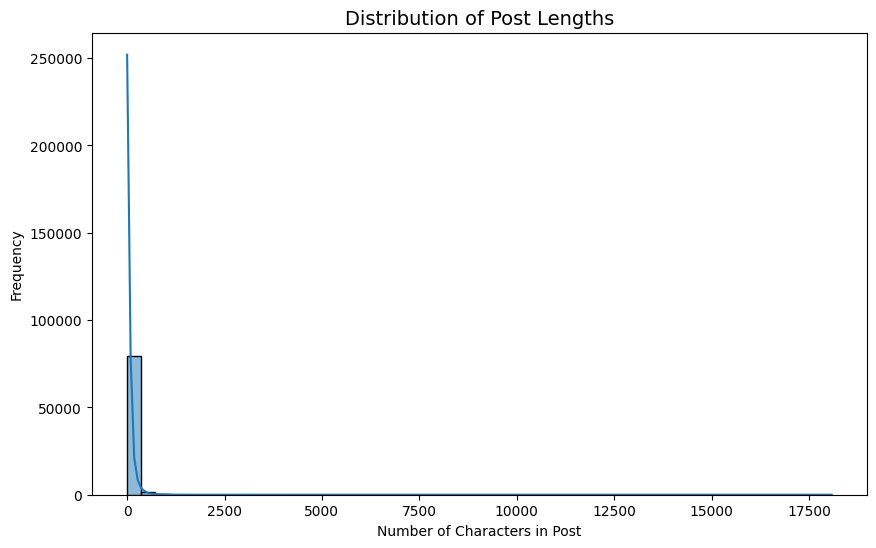

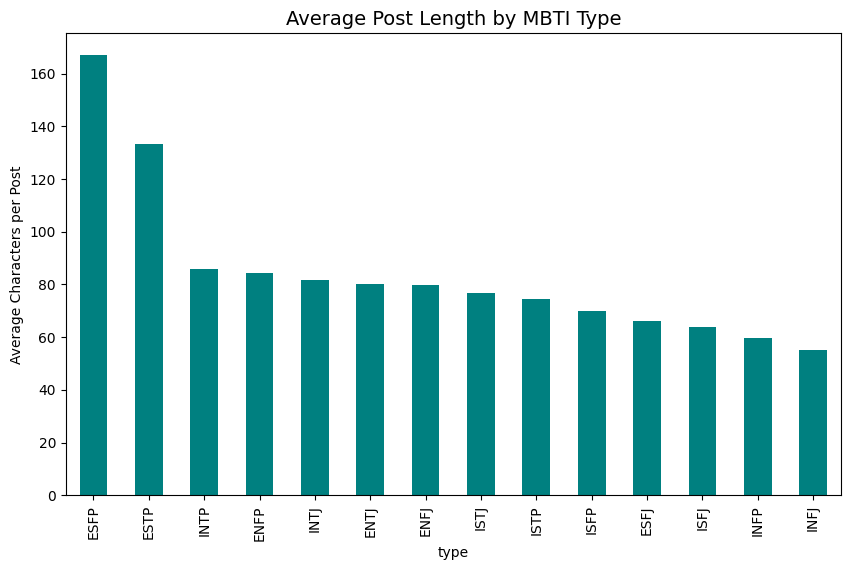


Average Post Length by MBTI Type:
 type
ESFP    166.975410
ESTP    133.106992
INTP     85.893422
ENFP     84.232472
INTJ     81.676889
ENTJ     80.072183
ENFJ     79.880324
ISTJ     76.858535
ISTP     74.559585
ISFP     69.785714
ESFJ     66.196615
ISFJ     63.658831
INFP     59.840024
INFJ     55.084948
Name: post_length, dtype: float64


In [5]:
mbti2['post_length'] = mbti2['cleaned_text'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(mbti2['post_length'], bins=50, kde=True)
plt.title("Distribution of Post Lengths", fontsize=14)
plt.xlabel("Number of Characters in Post")
plt.ylabel("Frequency")
plt.show()

avg_length = mbti2.groupby("type")["post_length"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
avg_length.plot(kind="bar", color="teal")
plt.title("Average Post Length by MBTI Type", fontsize=14)
plt.ylabel("Average Characters per Post")
plt.show()

print("\nAverage Post Length by MBTI Type:\n", avg_length)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23224\861639885.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_freq, x="count", y="word", palette="viridis")


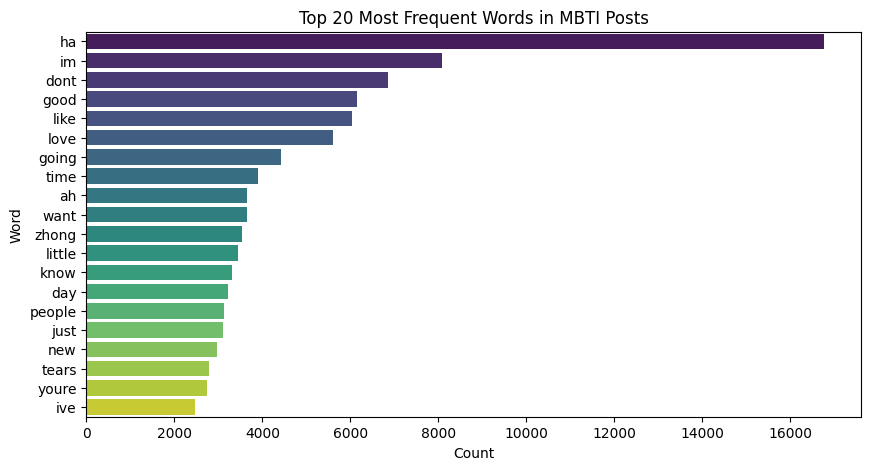

In [6]:
#Word Frequency Patterns top 20 most frequent words

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(mbti2["cleaned_text"])
word_freq = pd.DataFrame({
    "word": vectorizer.get_feature_names_out(),
    "count": np.ravel(X.sum(axis=0))
}).sort_values("count", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=word_freq, x="count", y="word", palette="viridis")
plt.title("Top 20 Most Frequent Words in MBTI Posts")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

In [7]:
#Summary 

print("\n--- EDA Summary ---")
print(f"Dataset size: {mbti2.shape[0]} posts")
print(f"Number of MBTI types: {mbti2['type'].nunique()}")
print("Most common type:", mbti2['type'].value_counts().idxmax())
print("Least common type:", mbti2['type'].value_counts().idxmin())
print("Average post length overall:", round(mbti2['post_length'].mean(), 2))
print("Most frequent words include:", ', '.join(word_freq['word'].head(5)))



--- EDA Summary ---
Dataset size: 81204 posts
Number of MBTI types: 14
Most common type: INFJ
Least common type: ESFP
Average post length overall: 66.9
Most frequent words include: ha, im, dont, good, like
